# Regresión logística para predicciones bancarias

## CARGAMOS NUESTROS MÓDULOS

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import statsmodels.api as sm
import math

# Para un modelo supervisado de ejemplo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

## Métricas de los modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## CARGAMOS NUESTRAS FUNCIONES

In [131]:
def encontrar_outliers(data,col):
    outliers=[]
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in data[col]:
        if out1>upper_limit or out1<lower_limit:
            outliers.append(out1)
    return np.array(outliers)

def graficos(data,col):
    fix,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.boxplot(y=data[col],ax=ax1)
    ax1.set_ylabel=col
    ax1.set_title('Gráfico de cajas de {}'.format(col))
    sns.histplot(data,x=col,kde=True,ax=ax2)
    ax2.set_title('Distribution plot of {}'.format(col))
    plt.axvline(data[col].mean(),color='red',linestyle='--')
    plt.legend(['densidad','media','distribución'])

def analisis_numerico(data,col):
    print('Cantidad de outlier:',len(encontrar_outliers(data,col)))
    print('Media:',round(data[col].mean(),3))
    print('Mediana:',data[col].median())
    print('Q1:',data[col].quantile(0.25))
    print('Q3:',data[col].quantile(0.75))
    print('max:',data[col].max())
    print('Asimetría:',round(sp.skew(data[col]),3))
    print('Kurtosis:',round(sp.kurtosis(data[col].max()),3))
    graficos(data,col)

def topcorrelaciones(data):
    cormatrix = data.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["Variable 1", "Variable 2", "correlación"]
    cormatrix=cormatrix.query('correlación!=0')
    return cormatrix

def describe_dataframe(df):
        column_descriptions = []

        for column in df.columns:
            #print(column)
            column_info = {}
            column_info['variable'] = column

            # Calcular el porcentaje de valores nulos
            null_percentage = df[column].isnull().mean() * 100
            column_info['nulos'] = round(null_percentage, 2)

            # Determinar el tipo de variable
            unique_values = df[column].nunique()
            total_values = len(df[column])
            if pd.api.types.is_object_dtype(df[column]): #pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_string_dtype(df[column]) or
                column_info['tipo'] = 'Categorical'
                column_info['etiquetas'] = unique_values
            elif pd.api.types.is_numeric_dtype(df[column]):
                if unique_values / total_values < 0.1:
                # if unique_values < 30:
                    column_info['tipo'] = 'Discrete'
                    column_info['etiquetas'] = unique_values
                else:
                    column_info['tipo'] = 'Continuous'
                    column_info['etiquetas'] = 'N/A'  # No aplicable para variables continuas
            else:
                column_info['tipo'] = 'Other'
                column_info['etiquetas'] = 'N/A'  # No aplicable para otras variables

            # Verificar la presencia de outliers (solo para variables numéricas)
            if pd.api.types.is_numeric_dtype(df[column]):
                q1 = df[column].quantile(0.25)
                q3 = df[column].quantile(0.85)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
                column_info['outliers'] = 'Yes' if outliers > 0 else 'No'
            else:
                column_info['outliers'] = 'N/A'  # No aplicable para variables no numéricas

            column_descriptions.append(column_info)

        return pd.DataFrame(column_descriptions)

## Cargadar Datos

In [132]:
data = pd.read_csv(r"C:\Users\dg_su\OneDrive - Universidad Tecnologica del Peru\Estudios\Cursos\Analisis de Datos\Universidad Ricardo Palma\ESTADISTICA CON PYTHON\codigo\base de datos\bank.csv", sep=";")

In [133]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


y
no     3668
yes     451
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='y'>

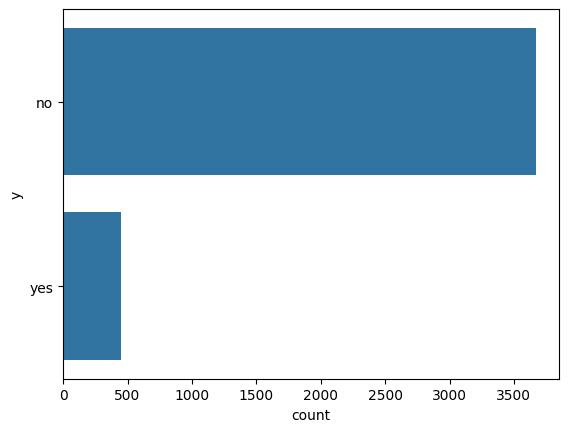

In [134]:
print(data.y.value_counts())
sns.countplot(y='y', data=data)

In [135]:
#transformar yes = 1,no = 0, yes = fuga de clientes
data["y"] = (data["y"]=="yes").astype(int)
print(data.y.value_counts())

y
0    3668
1     451
Name: count, dtype: int64


In [136]:
451/(451+3668)

0.10949259529011895

In [137]:
#funcion que describe si existe valores nules, el tipo de variable, etiquetas y si contiene outliers
var_ = describe_dataframe(data)
var_

,variable,nulos,tipo,etiquetas,outliers
0,age,0.0,Discrete,67,Yes
1,job,0.0,Categorical,12,N/A
2,marital,0.0,Categorical,4,N/A
3,education,0.0,Categorical,8,N/A
4,default,0.0,Categorical,3,N/A
5,housing,0.0,Categorical,3,N/A
6,loan,0.0,Categorical,3,N/A
7,contact,0.0,Categorical,2,N/A
8,month,0.0,Categorical,10,N/A
9,day_of_week,0.0,Categorical,5,N/A


## Exploración de Variables Categóricas

In [138]:
var_[var_["tipo"]=="Categorical"]

,variable,nulos,tipo,etiquetas,outliers
1,job,0.0,Categorical,12,N/A
2,marital,0.0,Categorical,4,N/A
3,education,0.0,Categorical,8,N/A
4,default,0.0,Categorical,3,N/A
5,housing,0.0,Categorical,3,N/A
6,loan,0.0,Categorical,3,N/A
7,contact,0.0,Categorical,2,N/A
8,month,0.0,Categorical,10,N/A
9,day_of_week,0.0,Categorical,5,N/A
14,poutcome,0.0,Categorical,3,N/A


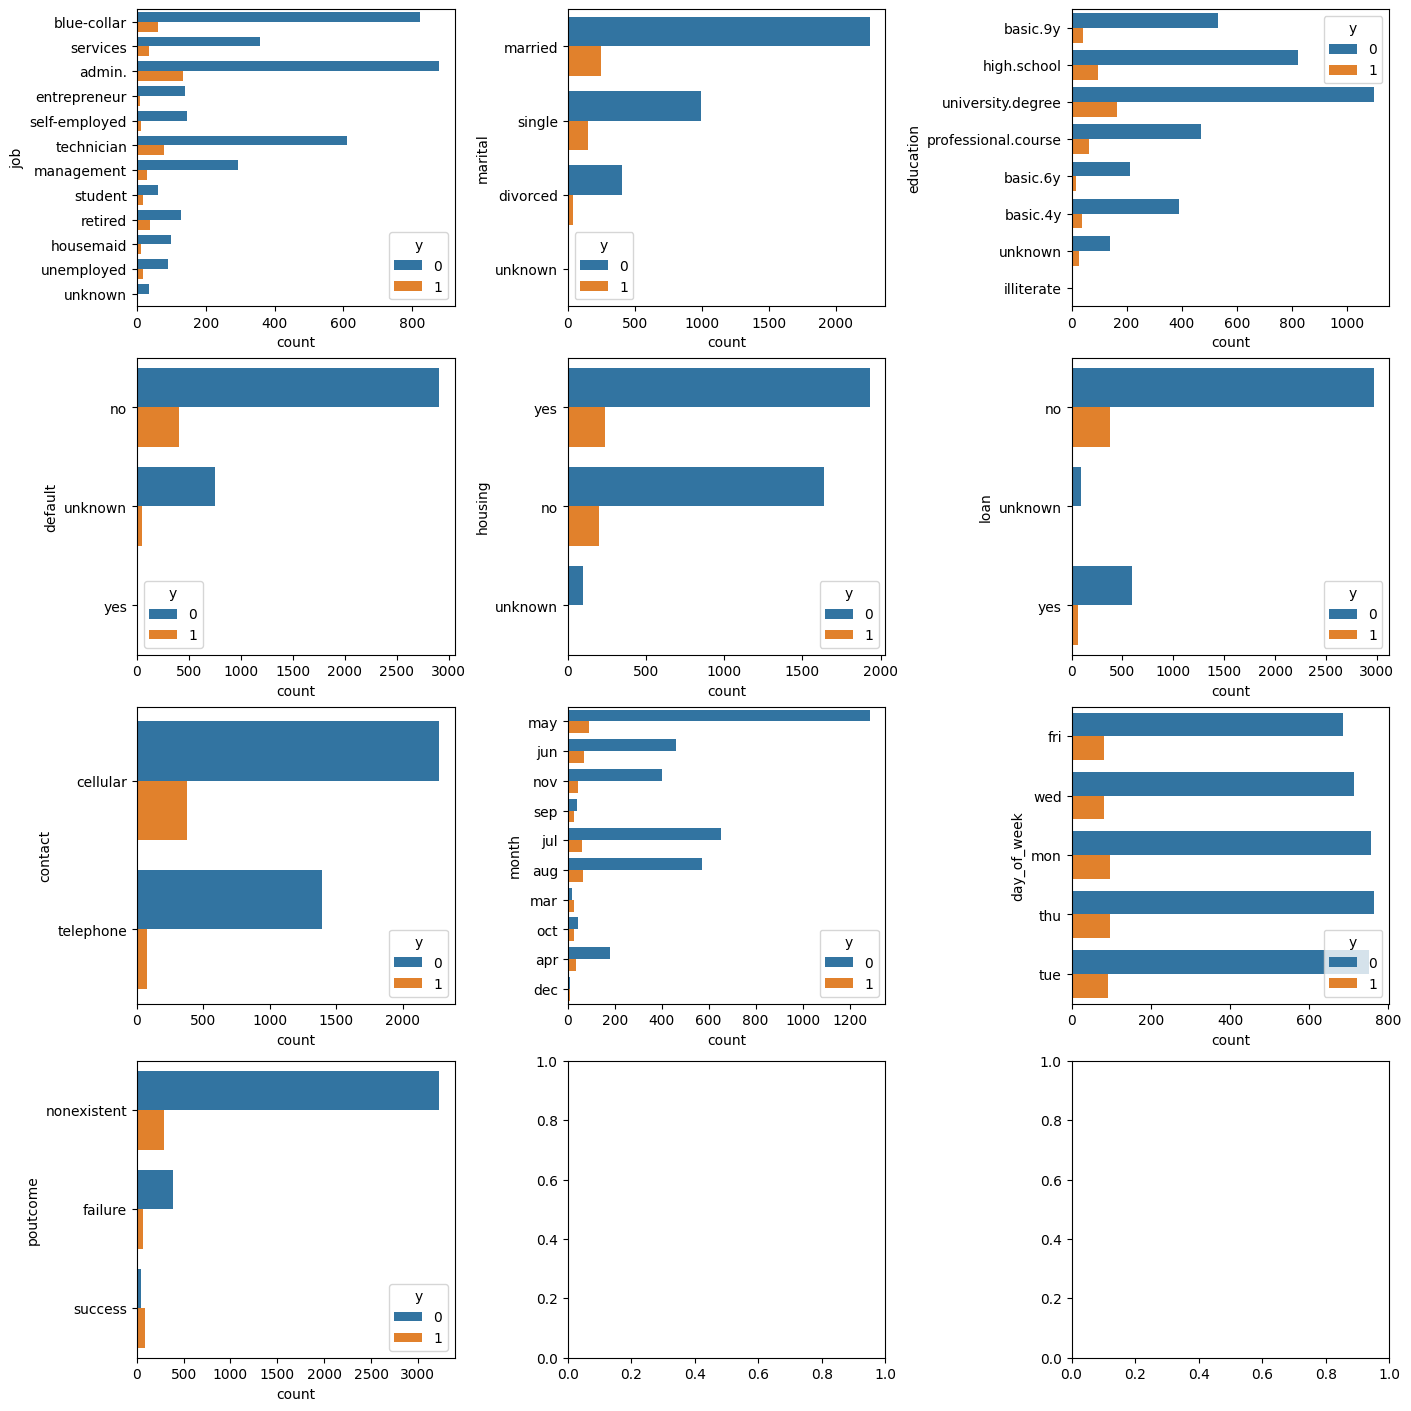

In [139]:
l_categorico = var_[var_["tipo"]=="Categorical"].variable.to_list()

c=3
r=math.ceil(len(l_categorico)/c)
fig, ax = plt.subplots(r,c,figsize=(14, 14),constrained_layout=True)
for i,j in zip(l_categorico,ax.ravel()):
    axx=sns.countplot(y=i, hue='y',data=data,ax=j) #, hue='y'

In [140]:
data["education"] = np.where(data["education"]=="basic.4y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.6y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.9y", "Basic", data["education"])

data["education"] = np.where(data["education"]=="high.school", "High School", data["education"])
data["education"] = np.where(data["education"]=="professional.course", "Professional Course", data["education"])
data["education"] = np.where(data["education"]=="university.degree", "University Degree", data["education"])

data["education"] = np.where(data["education"]=="illiterate", "Illiterate", data["education"])
data["education"] = np.where(data["education"]=="unknown", "Unknown", data["education"])

In [141]:
l_otros = var_[var_["tipo"]!="Categorical"].variable.to_list()
l_otros

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [142]:
data.groupby("y")[l_otros].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
y,,,,,,,,,,,
0,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072,0.0
1,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625,1.0


In [143]:
data.groupby("education")[l_otros].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
education,,,,,,,,,,,
Basic,42.337124,253.898457,2.429732,978.815597,0.149472,0.237368,93.658600,-41.120552,3.775701,5174.133144,0.079610
High School,38.097720,258.534202,2.630836,958.022801,0.206298,-0.002497,93.564314,-40.995765,3.511732,5163.212595,0.105320
Illiterate,42.000000,146.000000,4.000000,999.000000,0.000000,-2.900000,92.201000,-31.400000,0.834000,5076.200000,0.000000
Professional Course,40.207477,278.816822,2.512150,958.211215,0.194393,0.163925,93.599630,-40.127664,3.701426,5167.595140,0.121495
University Degree,39.017405,247.707278,2.583070,947.900316,0.207278,-0.009731,93.499109,-39.830063,3.547132,5163.023180,0.130538
Unknown,42.826347,267.281437,2.538922,939.700599,0.263473,-0.074251,93.637455,-39.487425,3.410174,5151.260479,0.155689


## Exploración de Variables Numéricas

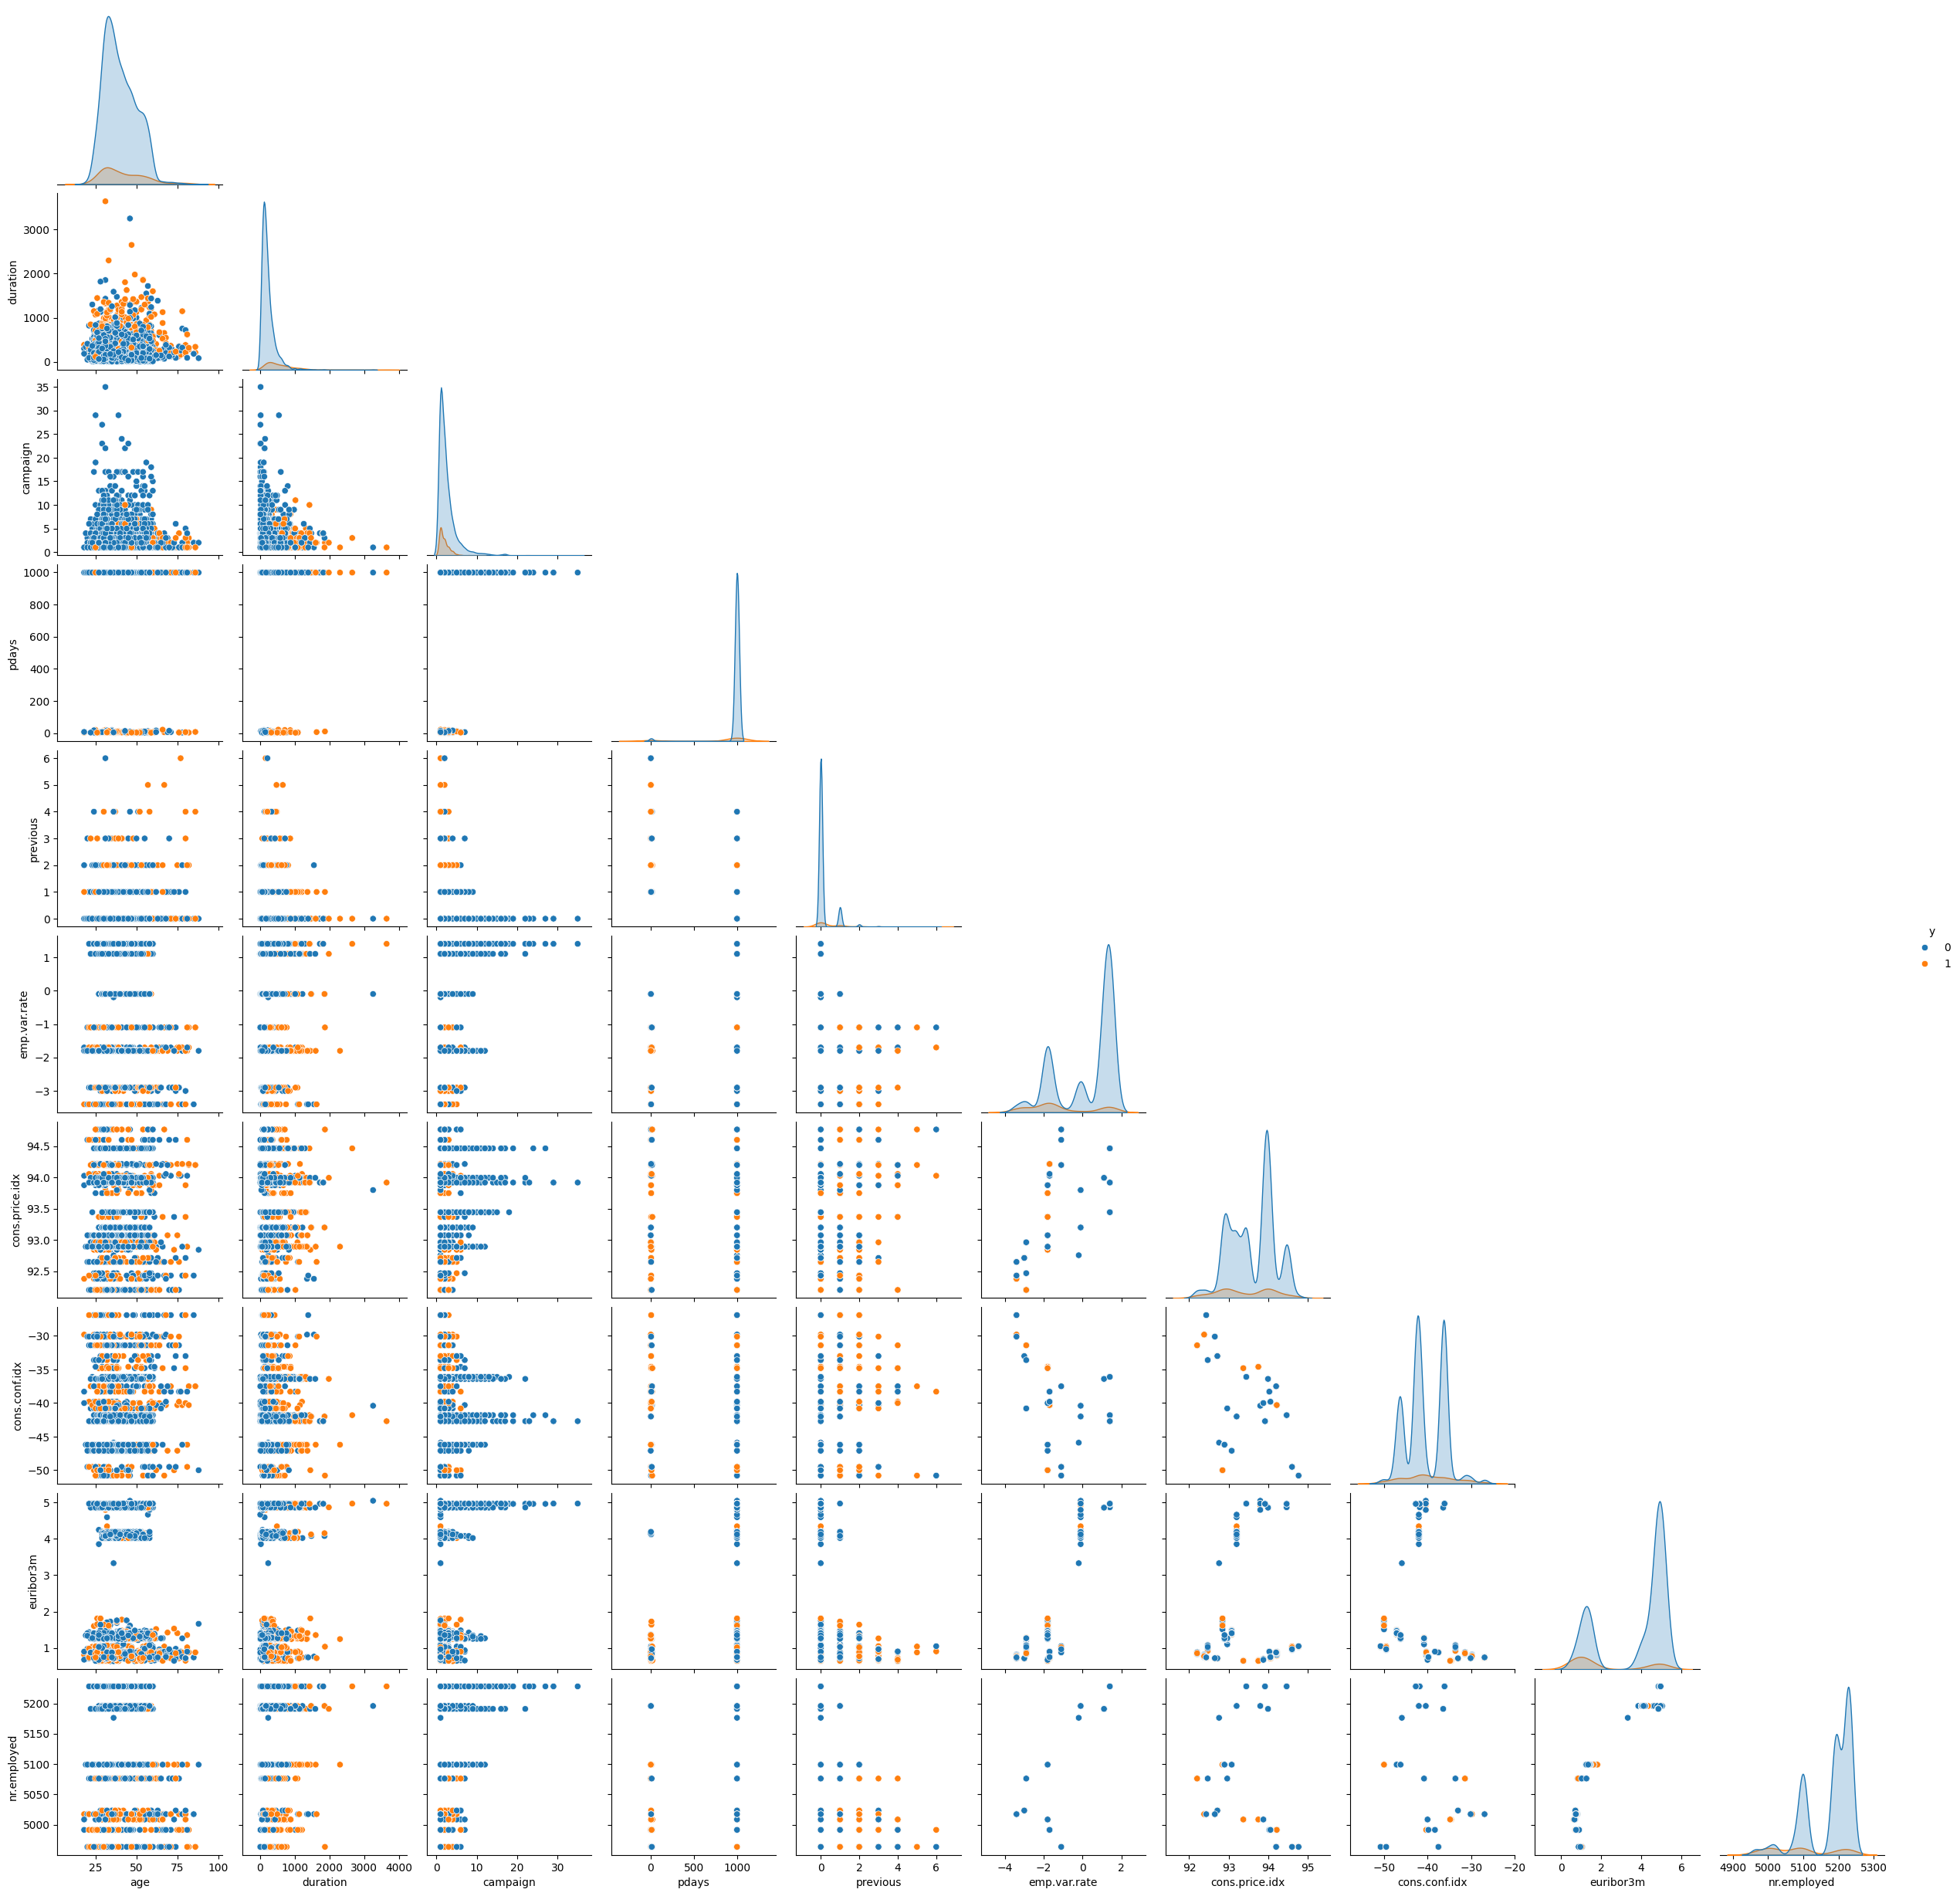

In [144]:
sns.pairplot(data[l_otros], hue="y", diag_kind="kde",  corner=True)

<Axes: >

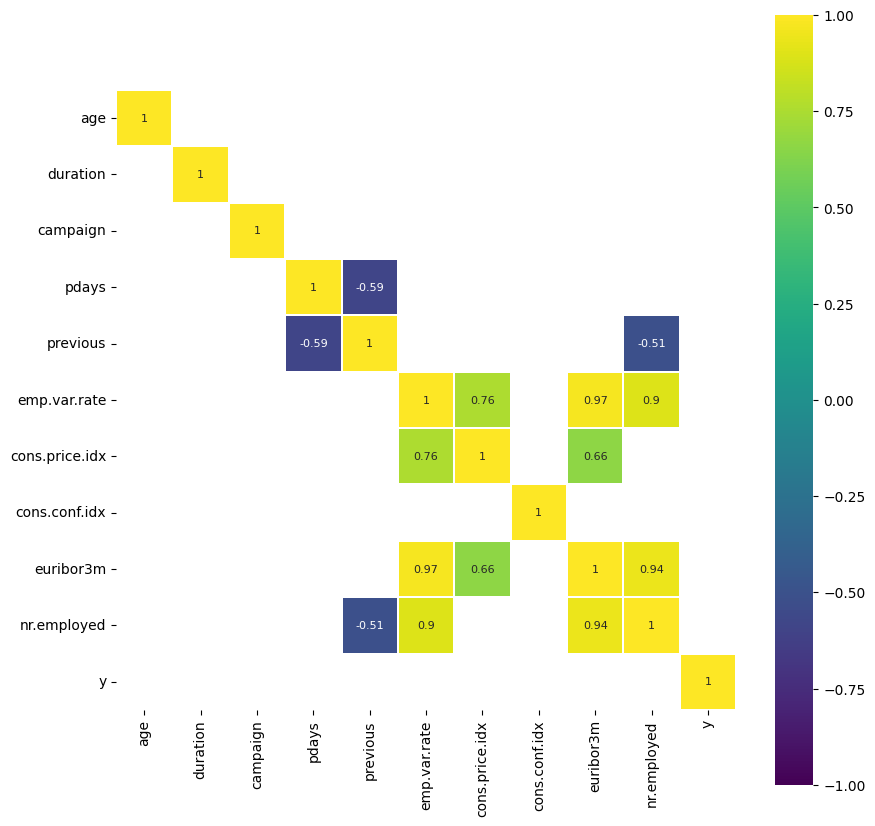

In [145]:
corr = data[l_otros].corr() # We already examined SalePrice correlations
plt.figure(figsize=(10, 10))
k = 0.5
sns.heatmap(corr[(corr >= k) | (corr <= -k)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### Conversión de las variables categóricas a dummies

In [146]:
# categories = ["job", "marital", "education", "housing", "loan", "contact",
#               "month", "day_of_week", "poutcome"]
# for category in categories:
#     cat_list = "cat"+ "_"+category
#     cat_dummies = pd.get_dummies(data[category], prefix=category)
#     data_new = data.join(cat_dummies)
#     data = data_new

### Target Enconding

In [147]:
import pandas as pd

def apply_target_encoding_mean(df, cat_column, target_column):
    """
    Aplica Target Encoding (usando la media) a una columna categórica en un DataFrame.

    Parameters:
    df (pd.DataFrame): El DataFrame que contiene los datos.
    cat_column (str): El nombre de la columna categórica a codificar.
    target_column (str): El nombre de la columna objetivo.

    Returns:
    pd.DataFrame: El DataFrame con la columna categórica codificada.
    """
    mean_encoded = df.groupby(cat_column)[target_column].mean()
    df[cat_column + '_encoded'] = df[cat_column].map(mean_encoded)
    return df

In [148]:
categories = ["job", "marital", "education", "housing", "loan", "contact",
              "month", "day_of_week", "poutcome","default"]

In [149]:
for category in categories:
  apply_target_encoding_mean(data, category, 'y')

In [150]:
data.drop(categories, axis=1, inplace=True) #eliminar la columna categoricas originales

In [151]:
data.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_encoded,marital_encoded,education_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,default_encoded
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0,0.069005,0.100438,0.079610,0.110345,0.111675,0.141403,0.065312,0.108073,0.082884,0.121267
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0,0.089059,0.134432,0.105320,0.109842,0.111675,0.051806,0.065312,0.108073,0.082884,0.121267
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0,0.089059,0.100438,0.105320,0.110345,0.111675,0.051806,0.128302,0.104403,0.082884,0.121267
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0,0.089059,0.100438,0.079610,0.085714,0.085714,0.051806,0.128302,0.108073,0.082884,0.121267
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,0.131423,0.100438,0.130538,0.110345,0.111675,0.141403,0.096413,0.114620,0.082884,0.121267


In [152]:
data.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_encoded', 'marital_encoded', 'education_encoded',
       'housing_encoded', 'loan_encoded', 'contact_encoded', 'month_encoded',
       'day_of_week_encoded', 'poutcome_encoded', 'default_encoded'],
      dtype='object')

In [153]:
Y = data['y']
X = data.drop('y',axis=1)

#### Normalización o Estandarización de datos

In [154]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])
    return df

def standardize(df, column):
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df[[column]])
    return df

In [155]:
# Normalizar
# for col in X.columns:
#   X = normalize(X, col)

In [156]:
# Estandarizar
for col in X.columns:
  X = standardize(X, col)

In [157]:
X.head() #se estandarizan los datos a una escala

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,education_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,default_encoded
0,-0.980752,0.903952,-0.209228,0.201031,-0.351356,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779,-0.994784,-0.580246,-1.317006,0.221144,0.422052,0.743752,-0.524456,-0.407723,-0.256536,0.492089
1,-0.107991,0.350300,0.569634,0.201031,-0.351356,0.649441,0.715193,0.892269,0.711698,0.332862,-0.502061,1.598262,-0.183884,0.090746,0.422052,-1.344534,-0.524456,-0.407723,-0.256536,0.492089
2,-1.465619,-0.116966,-0.598660,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.773427,0.836535,-0.502061,-0.580246,-0.183884,0.221144,0.422052,-1.344534,0.223280,-1.461839,-0.256536,0.492089
3,-0.204965,-0.941553,0.180203,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.771697,0.836535,-0.502061,-0.580246,-1.317006,-6.170196,-4.598186,-1.344534,0.223280,-0.407723,-0.256536,0.492089
4,0.667795,-0.780563,-0.598660,0.201031,-0.351356,-0.118350,-0.655478,-0.326707,0.328632,0.398028,0.538824,-0.580246,0.927528,0.221144,0.422052,0.743752,-0.155270,1.472525,-0.256536,0.492089


In [158]:
X.shape

(4119, 20)

## Selección de rasgos para el modelo

In [159]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [160]:
lr = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)

In [161]:
#encontrar los 12 mejores variables a analizar
rfe = RFE(lr, n_features_to_select=12)
rfe = rfe.fit(X, Y.values.ravel())

In [162]:
z=pd.DataFrame(zip(X.columns,rfe.support_, rfe.ranking_))
z.columns = ["variable", "selected", "rank"]

In [163]:
z[z['rank']==1]

,variable,selected,rank
1,duration,True,1
2,campaign,True,1
3,pdays,True,1
5,emp.var.rate,True,1
6,cons.price.idx,True,1
7,cons.conf.idx,True,1
8,euribor3m,True,1
9,nr.employed,True,1
10,job_encoded,True,1
12,education_encoded,True,1


In [164]:
cols = z[z['rank']==1].variable.to_list()
cols

['duration',
 'campaign',
 'pdays',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job_encoded',
 'education_encoded',
 'contact_encoded',
 'month_encoded']

In [165]:
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,education_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,default_encoded
0,-0.980752,0.903952,-0.209228,0.201031,-0.351356,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779,-0.994784,-0.580246,-1.317006,0.221144,0.422052,0.743752,-0.524456,-0.407723,-0.256536,0.492089
1,-0.107991,0.350300,0.569634,0.201031,-0.351356,0.649441,0.715193,0.892269,0.711698,0.332862,-0.502061,1.598262,-0.183884,0.090746,0.422052,-1.344534,-0.524456,-0.407723,-0.256536,0.492089
2,-1.465619,-0.116966,-0.598660,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.773427,0.836535,-0.502061,-0.580246,-0.183884,0.221144,0.422052,-1.344534,0.223280,-1.461839,-0.256536,0.492089
3,-0.204965,-0.941553,0.180203,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.771697,0.836535,-0.502061,-0.580246,-1.317006,-6.170196,-4.598186,-1.344534,0.223280,-0.407723,-0.256536,0.492089
4,0.667795,-0.780563,-0.598660,0.201031,-0.351356,-0.118350,-0.655478,-0.326707,0.328632,0.398028,0.538824,-0.580246,0.927528,0.221144,0.422052,0.743752,-0.155270,1.472525,-0.256536,0.492089


In [166]:
X = X[cols].astype(float)
X.head()

,duration,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,education_encoded,contact_encoded,month_encoded
0,0.903952,-0.209228,0.201031,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779,-0.994784,-1.317006,0.743752,-0.524456
1,0.350300,0.569634,0.201031,0.649441,0.715193,0.892269,0.711698,0.332862,-0.502061,-0.183884,-1.344534,-0.524456
2,-0.116966,-0.598660,0.201031,0.841389,1.528273,-0.283172,0.773427,0.836535,-0.502061,-0.183884,-1.344534,0.223280
3,-0.941553,0.180203,0.201031,0.841389,1.528273,-0.283172,0.771697,0.836535,-0.502061,-1.317006,-1.344534,0.223280
4,-0.780563,-0.598660,0.201031,-0.118350,-0.655478,-0.326707,0.328632,0.398028,0.538824,0.927528,0.743752,-0.155270


## Implementación del modelo en Python con scikit-learn

In [167]:
from sklearn import linear_model

In [168]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X,Y)

LogisticRegression()

In [169]:
logit_model.score(X,Y) #accuracy

0.9162418062636563

In [170]:
t_coeficientes = pd.DataFrame(list(zip(X.columns, np.transpose(logit_model.coef_[0]))))
t_coeficientes.columns = ["variable", "coeficiente"]
t_coeficientes['oddratio (OR)'] = np.exp(t_coeficientes['coeficiente'])
t_coeficientes

,variable,coeficiente,oddratio (OR)
0,duration,1.268311,3.554844
1,campaign,-0.235215,0.790401
2,pdays,-0.282454,0.753931
3,emp.var.rate,-1.356042,0.257679
4,cons.price.idx,1.105232,3.019925
5,cons.conf.idx,0.421920,1.524887
6,euribor3m,-1.004781,0.366125
7,nr.employed,0.926827,2.526480
8,job_encoded,0.077723,1.080823
9,education_encoded,0.094028,1.098591


**Definición básica:**
El OR representa el cambio en las probabilidades del resultado por cada unidad de aumento en la variable predictora.
Interpretación general:

- OR = 1: No hay asociación entre la variable predictora y el resultado.
- OR > 1: La variable predictora está asociada con mayores probabilidades del resultado.
- OR < 1: La variable predictora está asociada con menores probabilidades del resultado.


Ejemplos de interpretación:

- OR = 2: Las probabilidades del resultado se duplican por cada unidad de aumento en la variable predictora.
- OR = 0.5: Las probabilidades del resultado se reducen a la mitad por cada unidad de aumento en la variable predictora.

## Validación del modelo logístico

In [173]:
#Separar datos para prueba (test = 0.3) y entrenamiento (train = 0.7) 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=0)

In [174]:
print(X_train.shape)
print(X_test.shape)

(2883, 12)
(1236, 12)


In [175]:
#aplicar regresion logistica
lm = linear_model.LogisticRegression()
lm.fit(X_train, Y_train)

LogisticRegression()

In [176]:
from IPython.display import display, Math, Latex
display(Math(r'Y_p=\begin{cases}0& si\ p\leq0.5\\1&si\ p >0.5\end{cases}'))

<IPython.core.display.Math object>

In [177]:
probs = lm.predict_proba(X_test)
prediction = lm.predict(X_test)

In [178]:
#Funcion para encontrar el mejor UMBRAL (threshold)
from sklearn.metrics import roc_curve

def find_optimal_threshold(y_true, y_pred_prob):
    """
    Encuentra el umbral óptimo para las predicciones de un problema de clasificación binaria.

    Parameters:
    y_true (array-like): Valores verdaderos de la etiqueta de clase.
    y_pred_prob (array-like): Probabilidades predichas para la clase positiva.

    Returns:
    float: El umbral óptimo.
    """
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    # Calcular Youden's J
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [179]:
#Se utiliza para encontrar el mejor umbral, desde la cual se pueda decidir cual de los datos es 0 o 1
optimal_threshold = find_optimal_threshold(Y_test, probs[:,1])
optimal_threshold

0.10729454476090819

In [180]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, probs[:, 1] > 0.5)

array([[1074,   40],
       [  74,   48]], dtype=int64)

In [181]:
confusion_matrix(Y_test, probs[:, 1] > 0.1)

array([[922, 192],
       [ 15, 107]], dtype=int64)

## Matrices de Confusión y curvas ROC

In [184]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc

def evaluate_model(name_model, model, X_test, y_test):

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Calcular probabilidades para el cálculo de Gini
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc - 1
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Crear diccionario con las métricas
    metrics = {
        'Modelo': name_model,
        'AUC': auc,
        'Gini': gini,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

    return metrics

In [185]:
evaluate_model('Logistico_X_train', lm, X_train, Y_train)

{'Modelo': 'Logistico_X_train',
 'AUC': 0.9469953562324311,
 'Gini': 0.8939907124648623,
 'Accuracy': 0.9167533818938606,
 'Precision': 0.6893617021276596,
 'Recall': 0.49240121580547114,
 'F1-score': 0.574468085106383}

In [186]:
evaluate_model('Logistico_X_test', lm, X_test, Y_test)

{'Modelo': 'Logistico_X_test',
 'AUC': 0.9158769167377933,
 'Gini': 0.8317538334755865,
 'Accuracy': 0.9077669902912622,
 'Precision': 0.5454545454545454,
 'Recall': 0.39344262295081966,
 'F1-score': 0.45714285714285713}

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

def evaluate_binary_classifier(model, X, y, cv=5):
    """
    Evalúa un clasificador binario, muestra métricas clave y grafica la curva ROC.

    Parámetros:
    model: El modelo de clasificación a evaluar
    X: Características
    y: Etiquetas (0 o 1)
    cv: Número de folds para validación cruzada (por defecto 5)
    """

    # Obtener predicciones de probabilidad usando validación cruzada
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    y_pred = y_pred_proba[:, 1] > 0.5  # Convertir probabilidades a predicciones binarias

    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y, y_pred)

    # Imprimir el informe de clasificación
    print("Informe de Clasificación:")
    print(classification_report(y, y_pred))

    # Imprimir la matriz de confusión
    print("\nMatriz de Confusión:")
    print(cm)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1114
           1       0.54      0.25      0.35       122

    accuracy                           0.91      1236
   macro avg       0.73      0.62      0.65      1236
weighted avg       0.89      0.91      0.89      1236


Matriz de Confusión:
[[1088   26]
 [  91   31]]


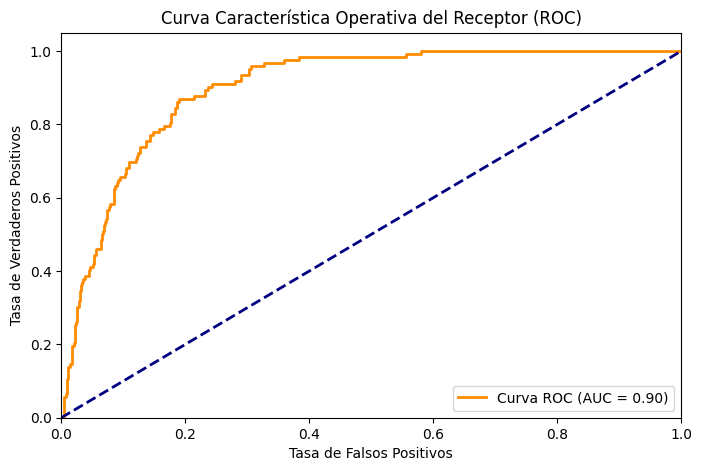


Puntuación AUC: 0.9007


In [188]:
# Evaluar el modelo
auc_score = evaluate_binary_classifier(lm, X_test, Y_test)
print(f"\nPuntuación AUC: {auc_score:.4f}")

Evaluar el modelo con un Nivel de Umbral Optimo (0.1)

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

def evaluate_binary_classifier(model, X, y, cv=5):
    """
    Evalúa un clasificador binario, muestra métricas clave y grafica la curva ROC.

    Parámetros:
    model: El modelo de clasificación a evaluar
    X: Características
    y: Etiquetas (0 o 1)
    cv: Número de folds para validación cruzada (por defecto 5)
    """

    # Obtener predicciones de probabilidad usando validación cruzada
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    y_pred = y_pred_proba[:, 1] > 0.10729  # Convertir probabilidades a predicciones binarias (Umbral Optimo)

    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y, y_pred)

    # Imprimir el informe de clasificación
    print("Informe de Clasificación:")
    print(classification_report(y, y_pred))

    # Imprimir la matriz de confusión
    print("\nMatriz de Confusión:")
    print(cm)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1114
           1       0.34      0.80      0.48       122

    accuracy                           0.83      1236
   macro avg       0.66      0.81      0.69      1236
weighted avg       0.91      0.83      0.85      1236


Matriz de Confusión:
[[925 189]
 [ 25  97]]


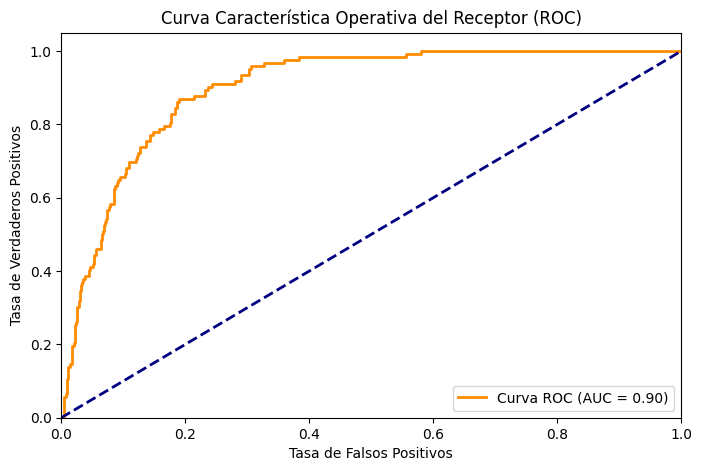


Puntuación AUC: 0.9007


In [191]:
# Evaluar el modelo con Umbral optimo
auc_score = evaluate_binary_classifier(lm, X_test, Y_test)
print(f"\nPuntuación AUC: {auc_score:.4f}")